In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import mediapipe as mp
from pathlib import Path
import time
rng = np.random.default_rng()

In [2]:
hands = mp.solutions.hands.Hands(static_image_mode=True,
                                max_num_hands=1,
                                min_detection_confidence=0.5)

<h3>Functions</h3>

get_hand_from_file(filepath)
get_hand_from_image(image)
    return: pair (exit_code, img_out) 
    exit_code is 1 on success and 0 on failure. 
    img_out is a cropping of the input image around the detected hand on success, the input image itself on failure.
    
rescale_square(image, size)
    return: the given image, up- or down-sampled to a square of side length <i>size</i>.
    assumes <i>image</i> has the shape of a square. if not, use square_and_rescale().
    if <i>image</i> already has the specified size, it's returned unaltered
    
square_and_rescale(image, size)
    return: a square image of side length <i>size</i>, containing <i>image</i> up- or down-sampled so that its longest side has the specified length, padded with noise or zeros if <i>image</i> is not already a square.
    the padding is randomly added above or below, or left or right, of the scaled image, as appropriate.
    will try to convert the given image's datatype to uint8, or if <i>datatype='float32'</i> is specified to float32.
    noise options are <i>fill_type=</i> 'uniform', 'gauss', or 'int' (or anything else for zeros). an exception will be raised if the random number type (float32 for 'uniform' and 'gauss', uint8 for 'int', anything for zeros) does not agree with the specified datatype for the image.

In [3]:
def clamp(x, y, size):
    x = max(0, min(x, size[1]))
    y = max(0, min(y, size[0]))
    return x,y

def get_bounding_box(landmark_values, image, pad_fraction = 0.2, pad_constant = 5):
    coord_list_x = []
    coord_list_y = []
    size = image.shape
    y_size, x_size, channels = size
    for landmark in landmark_values:
        coord_list_x.append(int(landmark.x * x_size))
        coord_list_y.append(int(landmark.y * y_size))
    x_min, x_max, y_min, y_max = min(coord_list_x), max(coord_list_x), min(coord_list_y), max(coord_list_y)
    x_pad, y_pad = pad_constant+int((x_max - x_min)*pad_fraction), pad_constant+int((y_max-y_min)*pad_fraction)
    top_left = clamp(x_min-x_pad, y_min-y_pad, size)
    bot_right = clamp(x_max+x_pad, y_max+y_pad, size)
    return image[top_left[1]:bot_right[1], top_left[0]:bot_right[0]]

def get_hand_from_file(filepath, warnings_list=[], pad_fraction = 0.2, pad_constant = 5):
    image = cv.flip(cv.imread(filepath), 1)
    results = hands.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    if not results.multi_hand_landmarks:
        print("Warning: hand not detected in image " + filepath)
        warnings_list.append(filepath)
        return (0,image)
    index = 0
    if len(results.multi_hand_landmarks) > 1:
        if results.multi_handedness[1].classification[0].label.lower() == "right":
            index = 1
    return (1, cv.flip(get_bounding_box(results.multi_hand_landmarks[index].landmark._values, image, 
                            pad_fraction=pad_fraction, pad_constant=pad_constant), 1))

def get_hand_from_image(image, colour = 'rgb', warnings_list=[], pad_fraction = 0.2, pad_constant = 5, quiet=True):
    if colour.lower() == 'bgr':
        results = hands.process(cv.flip(cv.cvtColor(image, cv.COLOR_BGR2RGB),1))
    else:
        results = hands.process(cv.flip(image,1))        
    if not results.multi_hand_landmarks:
        if not quiet:
            print("Warning: hand not detected in image.")
        warnings_list.append(image)
        return (0,image)
    return (1, get_bounding_box(results.multi_hand_landmarks[0].landmark._values, image, 
                            pad_fraction=pad_fraction, pad_constant=pad_constant))

In [22]:
#ChicagoFSWild/frames/platform/channel/frame files

inpath = Path("ChicagoFSWild/frames/")
outpath = "temp/"

warnings_list = []

excount=0
nondetect=0
justnow = time.time()

for platform in inpath.iterdir():
    print("Opening ", platform)
    out_platform = outpath + platform.name
    Path(out_platform).mkdir(exist_ok=True)
    
    for seq in platform.iterdir():
        print("Opening ", seq)
        out_seq = out_platform +"/"+ seq.name
        Path(outpath+platform.name+'/'+seq.name).mkdir(exist_ok=True)
        
        for frame in seq.iterdir():
            try:
                ret, hand = get_hand_from_file(str(frame), warnings_list=warnings_list)
                if ret == 0:
                    nondetect+=1
                else:
                    fileout = "temp/" +platform.name + "/" + seq.name + "/"  + frame.name
                    cv.imwrite(fileout, hand)
            except:
                print("Something went wrong: ", fileout)
                excount+=1
now = time.time()
print("Elapsed time:", now-justnow)
print(excount, nondetect)

Opening  ChicagoFSWild\frames\aslized
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_1745
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_1759
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_1760
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_7219
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_7220
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_7221
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_7222
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_7223
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_7224
Opening  ChicagoFSWild\frames\aslized\ben_jarashow_7225
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0001
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0002
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0003
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0004
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0005
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0006
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0007
Ope

Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0105
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0106
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0107
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0108
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0109
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0110
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0111
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0112
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0113
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0114
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0115
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0116
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0117
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0118
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0119
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0120
Opening  ChicagoFSWild\frames\aslized\elsie_stecker_0121
Opening  ChicagoFSWild\frames\a

Opening  ChicagoFSWild\frames\aslized\joseph_hill_0135
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0136
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0137
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0138
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0139
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0140
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0141
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0142
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0143
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0144
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0145
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0146
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0147
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0148
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0149
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0150
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0151
Opening  ChicagoFSWild\frames\aslized\joseph_hill_0152
Opening  C

Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7045
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7046
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7047
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7048
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7049
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7050
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7051
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7052
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7053
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7054
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7055
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7056
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7057
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7058
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7059
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7060
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7061
Opening  ChicagoFSWild\frames\aslized\mj_bienvenu_7062
Opening  C

Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0196
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0197
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0198
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0199


Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0200
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0201
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0202


Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0203
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0204
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0205
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0206


Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0207
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0208
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0241
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0242
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0243
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0244
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0245
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0246
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0247
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0248
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0249
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0250
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0251
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0252
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0253
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_0254
Opening  ChicagoFSWild\frames\aslized\suzanne_stecker_02

Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0312
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0313
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0314
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0315
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0316
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0317
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0318
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0319
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0320
Opening  ChicagoFSWild\frames\aslized\unknown_female_1_0321
Opening  ChicagoFSWild\frames\aslized\unknown_female_3_0288
Opening  ChicagoFSWild\frames\aslized\unknown_female_3_0289
Opening  ChicagoFSWild\frames\aslized\unknown_female_4_0294
Opening  ChicagoFSWild\frames\aslized\unknown_female_4_0295
Opening  ChicagoFSWild\frames\aslized\unknown_female_5_0296
Opening  ChicagoFSWild\frames\aslized\unknown_female_6_0298
Opening  ChicagoFSWild\frames\aslized\un

Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0520
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0521
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0522
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0523
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0524
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0525
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0526
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0527
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0528
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0529
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0530
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0531
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0532
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0533
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0534
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0535
Opening  ChicagoFSWild\frames\aslthat\joseph_wheeler_0536
Opening  Chica

Opening  ChicagoFSWild\frames\awti\austin_andrews_0655
Opening  ChicagoFSWild\frames\awti\austin_andrews_0656
Opening  ChicagoFSWild\frames\awti\austin_andrews_0657
Opening  ChicagoFSWild\frames\awti\austin_andrews_0658
Opening  ChicagoFSWild\frames\awti\austin_andrews_0659
Opening  ChicagoFSWild\frames\awti\austin_andrews_0660
Opening  ChicagoFSWild\frames\awti\austin_andrews_0661
Opening  ChicagoFSWild\frames\awti\austin_andrews_0662
Opening  ChicagoFSWild\frames\awti\austin_andrews_0663
Opening  ChicagoFSWild\frames\awti\austin_andrews_0664
Opening  ChicagoFSWild\frames\awti\austin_andrews_0665
Opening  ChicagoFSWild\frames\awti\austin_andrews_0666
Opening  ChicagoFSWild\frames\awti\austin_andrews_0667
Opening  ChicagoFSWild\frames\awti\austin_andrews_0668
Opening  ChicagoFSWild\frames\awti\austin_andrews_0669
Opening  ChicagoFSWild\frames\awti\austin_andrews_0670
Opening  ChicagoFSWild\frames\awti\austin_andrews_0671
Opening  ChicagoFSWild\frames\awti\austin_andrews_0672
Opening  C

Opening  ChicagoFSWild\frames\awti\austin_andrews_0799
Opening  ChicagoFSWild\frames\awti\austin_andrews_0800
Opening  ChicagoFSWild\frames\awti\austin_andrews_0801
Opening  ChicagoFSWild\frames\awti\austin_andrews_0802
Opening  ChicagoFSWild\frames\awti\austin_andrews_0803
Opening  ChicagoFSWild\frames\awti\austin_andrews_0804
Opening  ChicagoFSWild\frames\awti\austin_andrews_0805
Opening  ChicagoFSWild\frames\awti\austin_andrews_0806
Opening  ChicagoFSWild\frames\awti\austin_andrews_0807
Opening  ChicagoFSWild\frames\awti\austin_andrews_0808
Opening  ChicagoFSWild\frames\awti\austin_andrews_0809
Opening  ChicagoFSWild\frames\awti\austin_andrews_0810
Opening  ChicagoFSWild\frames\awti\austin_andrews_0811
Opening  ChicagoFSWild\frames\awti\austin_andrews_0812
Opening  ChicagoFSWild\frames\awti\austin_andrews_0813
Opening  ChicagoFSWild\frames\awti\austin_andrews_0814
Opening  ChicagoFSWild\frames\awti\austin_andrews_0815
Opening  ChicagoFSWild\frames\awti\austin_andrews_0816
Opening  C

Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0874
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0875
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0876
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0877
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0878
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0879
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0880
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0881
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0882
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0883
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0884
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0885
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_0886
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1152
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1153
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1154
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_11

Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1164
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1165
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1166
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1167
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1168
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1169
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1170
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1171
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1172
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1173
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1174
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1175
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1176
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1177
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1178
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1179
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_11

Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1185
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1186
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1187
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1188
Opening  ChicagoFSWild\frames\deafvideo_1\deafaynrand_1189
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0837
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0838
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0839
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0840
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0841
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0842
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0843
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0844
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0845
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0846
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_0847
Opening  ChicagoFSWild\

Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1191
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1192
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1193
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1194
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1195
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1196
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1197
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1198
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1199
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1200
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1201
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1202
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1203
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1204
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1205
Opening  ChicagoFSWild\frames\deafvideo_1\deafwomynpride_1206
Opening 

Opening  ChicagoFSWild\frames\deafvideo_1\michael_moore_0989
Opening  ChicagoFSWild\frames\deafvideo_1\paul_sabila_0986
Opening  ChicagoFSWild\frames\deafvideo_1\paul_sabila_0987


Opening  ChicagoFSWild\frames\deafvideo_1\paul_sabila_0988


Opening  ChicagoFSWild\frames\deafvideo_1\rusty_nawrocki_0995
Opening  ChicagoFSWild\frames\deafvideo_1\rusty_nawrocki_0996
Opening  ChicagoFSWild\frames\deafvideo_1\rusty_nawrocki_0997
Opening  ChicagoFSWild\frames\deafvideo_1\rusty_nawrocki_0998
Opening  ChicagoFSWild\frames\deafvideo_1\rusty_nawrocki_0999
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1225
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1226
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1227
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1228
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1229
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1230
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1231
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1232
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1233
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1234
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1235
Opening  ChicagoFSWild\frames\deafvideo_1\taylerade_1236
Openin

Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1042
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1043
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1044
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1045
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1046
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1047
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1048
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1049
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1050
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1051
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1052
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1053
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1054
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1055
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1056
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_1057
Opening  ChicagoFSWild\frames\deafvideo_1\thedeafmoth_10

Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0888
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0889
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0890


Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0891
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0892
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0893
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0894
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0895
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0896
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0897
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0898
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0899
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0900
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0901
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0902
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0903
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0904
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0905
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0906
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_09

Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0909
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0910
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0911
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0912
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0913
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0914
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0915
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0916
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0917
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0918
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0919
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0920
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0921
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0922
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0923
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0924
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_09

Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0941
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0942
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0943
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0944
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0945
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0946
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0947
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0948
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0949
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0950
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0951
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0952
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0953
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0954
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0955
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_0956
Opening  ChicagoFSWild\frames\deafvideo_1\wesley_arey_09

Opening  ChicagoFSWild\frames\deafvideo_1\willearl2_1287
Opening  ChicagoFSWild\frames\deafvideo_1\willearl2_1288
Opening  ChicagoFSWild\frames\deafvideo_1\willearl2_1289
Opening  ChicagoFSWild\frames\deafvideo_2
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2959
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2960
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2961
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2962
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2963
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2964
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2965
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2966
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2967
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2968
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2969
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2970
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2971
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2972
Opening  ChicagoFSWild\frames\d

Opening  ChicagoFSWild\frames\deafvideo_2\archie_2975
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2976
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2977
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2978
Opening  ChicagoFSWild\frames\deafvideo_2\archie_2979
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1661
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1662
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1663
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1664
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1665
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1666
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1667
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1668
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1669
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1670
Opening  ChicagoFSWild\frames\deafvideo_2\confederateboy_1671
Opening  ChicagoFSWild\frames\deafvideo_2\confed

Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1782
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1783
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1784
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1785
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1786
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1787
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1788
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1789
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1790
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1791
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1792
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1793
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1794
Opening  ChicagoFSWild\frames\deafvideo_2\deafpoweronethumbtwo_1795
Opening  ChicagoFSWild\frames\deafvideo_2\deafpo

Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1495
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1496
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1497
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1498
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1499
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1500
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1501
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1502
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1503
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1504
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1505
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1506
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1507
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1508
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1509
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1510
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1511


Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1512
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1513
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1514
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1515
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1516
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1517
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1518
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1598
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1599
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1600
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1601
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1602
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1603
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1604
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1605
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1606
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1607
Opening  ChicagoFSWild\frames\deafvideo_2\dsport

Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1629
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1630
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1631
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1632
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1633
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1634
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1635
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1636
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1637
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1638
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1639
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1640
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1641
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1642
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1643
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1644
Opening  ChicagoFSWild\frames\deafvideo_2\dsport06_1645
Opening  ChicagoFSWild\frames\deafvideo_2\dsport

Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2275
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2276
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2277
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2278
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2279
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2280
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2281
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2282
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2283
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2284
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2285
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2286
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2287
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2288


Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2289
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2290
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2291
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2292
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2293
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2294
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2295
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2296
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2297
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2298
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2299
Opening  ChicagoFSWild\frames\deafvideo_2\fairytales9_2300
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1324
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1325
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1326
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1327
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1328
Opening  ChicagoFSWild

Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1356
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1357
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1358
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1359
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1360
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1361
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1362
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1363
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1364
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1365
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1366
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1367
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1368
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1369
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1370
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1371
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1372
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1373
Opening  ChicagoFSWild\frame

Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1418
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1419
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1420
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1421
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1422
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1423
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1424
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1425
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1426
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1427
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1428
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1429
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1430
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1431
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1432
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1433
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1434
Opening  ChicagoFSWild\frames\deafvideo_2\frekky_1435
Opening  ChicagoFSWild\frame

Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1527
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1528
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1529
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1530
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1531
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1532
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1533
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1534
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1535
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1536
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1537


Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1538
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1539
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1540
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1541
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1542
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1543


Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1544
Opening  ChicagoFSWild\frames\deafvideo_2\goatman_1545
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1682
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1683
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1684
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1685
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1686
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1687
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1688
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1689
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1690
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1691
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1692
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1693
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1694
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1695
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica_1696
Opening  ChicagoFSWild\frames\deafvideo_2\jamerica

Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1584
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1585
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1586
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1587
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1588
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1589
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1590
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1591
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1592
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1593
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1594
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1595
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1596
Opening  ChicagoFSWild\frames\deafvideo_2\sddsimple_1597
Opening  ChicagoFSWild\frames\deafvideo_2\tar2006_1443
Opening  ChicagoFSWild\frames\deafvideo_2\tar2006_1444
Opening  ChicagoFSWild\frames\deafvideo_2\tar2006_1445
Opening  ChicagoFSWild\frames\deafvid

Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1479
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1480
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1481
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1704
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1705
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1706
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1707
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1708
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1709
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1710
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1711
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1712
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1713
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1714
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1715
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1716
Opening  ChicagoFSWild\frames\deafvideo_2\willearl2_1717
Opening  ChicagoFSWild\frames\d

Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3601
Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3602
Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3603
Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3604
Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3605
Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3606


Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3607
Opening  ChicagoFSWild\frames\deafvideo_3\damien23_3608
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4389
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4390
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4391
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4392
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4393
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4394
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4395
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4396
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4397
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4398
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4399
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4400
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4401
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4402
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4403
Ope

Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4457
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4458
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4459
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4460
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4461
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4462
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4463
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4464
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4465
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4466
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4467
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4468
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4469
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4470
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4481
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_4482
Opening  ChicagoFSWild\frames\deafvideo_3\deafaynrand_44

Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3076
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3077
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3078
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3079
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3080
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3081
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3082
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3084
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3085
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3086
Opening  ChicagoFSWild\frames\deafvideo_3\deafgoldenhair_3087
Opening  ChicagoFSWild\frames\deafvideo_3\deafmermaid_3689
Opening  ChicagoFSWild\frames\deafvideo_3\deafmermaid_3690
Opening  ChicagoFSWild\frames\deafvideo_3\deafmermaid_3691
Opening  ChicagoFSWild\frames\deafvideo_3\deafmermaid_3692
Opening  ChicagoFSWild\frames\deafvideo_3\deafmermaid_3693
Opening  ChicagoFSWild\

Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3570
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3571
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3572
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3573
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3574
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3575
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3576
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3577
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3578
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3579
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3580
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3581
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3582
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3583
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3584
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_3585
Opening  ChicagoFSWild\frames\deafvideo_3\dogwood1214_35

Opening  ChicagoFSWild\frames\deafvideo_3\joan_3626
Opening  ChicagoFSWild\frames\deafvideo_3\joan_3627
Opening  ChicagoFSWild\frames\deafvideo_3\joan_3628
Opening  ChicagoFSWild\frames\deafvideo_3\joan_3629
Opening  ChicagoFSWild\frames\deafvideo_3\joan_3630
Opening  ChicagoFSWild\frames\deafvideo_3\joan_3631
Opening  ChicagoFSWild\frames\deafvideo_3\joan_3632
Opening  ChicagoFSWild\frames\deafvideo_3\joan_3633
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3237
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3238
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3239
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3240
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3241
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3242
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3243
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3244
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3245
Opening  ChicagoFSWild\frames\deafvideo_3\joy_life_3246
Opening  ChicagoFSWild\f

Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3472
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3473
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3474
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3475
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3476
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3477
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3478
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3479
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3480
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3481
Opening  ChicagoFSWild\frames\deafvideo_3\kathyfans_3482
Opening  ChicagoFSWild\frames\deafvideo_3\kazio63_3500
Opening  ChicagoFSWild\frames\deafvideo_3\kazio63_3501
Opening  ChicagoFSWild\frames\deafvideo_3\kazio63_3502
Opening  ChicagoFSWild\frames\deafvideo_3\kazio63_3503
Opening  ChicagoFSWild\frames\deafvideo_3\kazio63_3504
Opening  ChicagoFSWild\frames\deafvideo_3\kazio63_3505
Opening  ChicagoFSWild\frames\deafvideo_3\k

Opening  ChicagoFSWild\frames\deafvideo_3\titans_4694
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4695
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4696
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4697
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4698
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4699
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4700
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4701
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4702
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4703
Opening  ChicagoFSWild\frames\deafvideo_3\titans_4704
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4624
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4625
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4626
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4627
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4628
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4629
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4630
Opening  Chica

Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4634
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4635
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4636
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4637
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4638
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4639
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4640
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4641
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4642
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4643
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4644
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4645
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4646
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4647
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4648
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4649
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4650
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakl

Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4658
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4659
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4660
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4661
Opening  ChicagoFSWild\frames\deafvideo_3\wnoakley_4662
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4663
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4664
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4665
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4666
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4667
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4668
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4669
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4670
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4671
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4672
Opening  ChicagoFSWild\frames\deafvideo_3\yellowbirdie84_4673
Opening  ChicagoFSWild\frames\deafvide

Opening  ChicagoFSWild\frames\deafvideo_4\chsasldeafnews_5217
Opening  ChicagoFSWild\frames\deafvideo_4\chsasldeafnews_5218
Opening  ChicagoFSWild\frames\deafvideo_4\chsasldeafnews_5219
Opening  ChicagoFSWild\frames\deafvideo_4\chsasldeafnews_5220
Opening  ChicagoFSWild\frames\deafvideo_4\chsasldeafnews_5221
Opening  ChicagoFSWild\frames\deafvideo_4\chsasldeafnews_5222
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5042
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5043
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5044
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5045
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5046
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5047
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5048
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5049
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5050
Opening  ChicagoFSWild\frames\deafvideo_4\deafmermaid_5051
Opening  ChicagoFSWild\frames\deafvide

Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5003
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5004
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5005
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5006
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5007
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5008
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5009
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5010
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5011
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5012
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5013
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5014
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5015
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5016
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5017
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_5018
Opening  ChicagoFSWild\frames\deafvideo_4\deafvideotv_50

Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4914
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4915
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4916
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4917
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4918
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4919
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4920
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4921
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4922
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4923
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4924
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4925
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4926
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4927
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4928
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4929
Opening  ChicagoFSWild\frames\deafvideo_4\dsport06_4930
Opening  ChicagoFSWild\frames\deafvideo_4\dsport

Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5691
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5692
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5693
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5694
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5695
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5696
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5697
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5698
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5699
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5700
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5701
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5702
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5703
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5704
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5705
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5706
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_57

Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5724
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5725
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5726
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_5727
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6062
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6063
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6064
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6065
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6066
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6067
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6068
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6069
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6070
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6071
Opening  ChicagoFSWild\frames\deafvideo_4\floridaaahh_6072
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4965
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4966
Opening

Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4975
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4976
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4977
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4978
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4979
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4980
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4981
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4982
Opening  ChicagoFSWild\frames\deafvideo_4\frekky_4983
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5223
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5224
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5225
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5226
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5227
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5228
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5229
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5230
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5231
Opening  ChicagoFSWild\frame

Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5233
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5234
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5235
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5236
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5237
Opening  ChicagoFSWild\frames\deafvideo_4\lukass_5238
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5138
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5139
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5140
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5141
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5142
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5143
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5144
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5145
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5146
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5147
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5148
Opening  ChicagoFSWild\fram

Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5164
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5165
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5166
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5167
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5168
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5169
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5170
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5171
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5172
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5173
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5174
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5175
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5176
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5177
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5178
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5179
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_51

Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5199
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5200
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5201
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5202
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5203
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5204
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5205
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5206
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5207
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5208
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5209
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5210
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5211
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5212
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5213
Opening  ChicagoFSWild\frames\deafvideo_4\mattref2005_5214
Opening  ChicagoFSWild\frames\deafvideo_4\shebaby_4993
O

Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5619
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5620
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5621
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5622
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5623
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5624
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5625
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5626
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5628
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5629
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5630
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5631
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5637
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5638
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5639
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5640
Opening  ChicagoFSWild\frames\deafvideo_4\taylerade_5641
Opening  ChicagoFSWild\frames\d

Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7308
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7309
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7310
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7311
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7312
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7313
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7314
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7371
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7372
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7373
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7374
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7375


Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7376
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7377
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7378
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7379
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7380
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7381
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7382
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7383
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7384
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7385


Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7386
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7387
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7388
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7389
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7390
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7391
Opening  ChicagoFSWild\frames\deafvideo_5\brooklyn_7392
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6533
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6534
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6535
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6536
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6537
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6538
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6539
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6540
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6541
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6542
Opening  ChicagoFS

Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6549
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6550
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6551
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6552
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6553
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6554
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6555
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6556
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6557
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6558
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6559
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6560
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6561
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6562
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6563
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6564
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_65

Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6573
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6574
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6575
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6576
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6577
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6578
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6579
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6580
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6581
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6582
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6583
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6584
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6585
Opening  ChicagoFSWild\frames\deafvideo_5\deafaynrand_6586
Opening  ChicagoFSWild\frames\deafvideo_5\deafcutecartoon_6367
Opening  ChicagoFSWild\frames\deafvideo_5\deafcutecartoon_6368
Opening  ChicagoFSWild\frames\deafvideo_5\deafcu

Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7333
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7334
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7335
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7336
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7337
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7338
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7339
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7340
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7341
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7342
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7343
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7344
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7345
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7346
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7347
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_7348
Opening  ChicagoFSWild\frames\deafvideo_5\deafmermaid_73

Opening  ChicagoFSWild\frames\deafvideo_5\deafvideotv_7285
Opening  ChicagoFSWild\frames\deafvideo_5\deafvideotv_7286
Opening  ChicagoFSWild\frames\deafvideo_5\deafvideotv_7287
Opening  ChicagoFSWild\frames\deafvideo_5\deafvideotv_7288
Opening  ChicagoFSWild\frames\deafvideo_5\deafvideotv_7289
Opening  ChicagoFSWild\frames\deafvideo_5\deafvideotv_7290
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6374
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6375
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6376
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6377
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6378
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6379
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6380
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6381
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6382
Opening  ChicagoFSWild\frames\deafvideo_5\dirtyoldman55_6383
Opening  ChicagoFSWild\frames\deafvi

Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7136
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7137
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7138
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7139
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7140
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7141
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7142
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7143
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7144
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7145
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7146
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7147
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7148
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7149
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7150
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7151
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7152
Opening  ChicagoFSWild\frames\deafvideo_5\jddeaf_7153
Opening  ChicagoFSWild\frame

Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6252
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6253
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6254
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6255
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6256
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6257
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6258
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6259
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6260
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6261
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6262
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6263
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6264
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6265
Opening  ChicagoFSWild\frames\deafvideo_5\morningstar_6266
Opening  ChicagoFSWild\frames\deafvideo_5\redneckmoose85_6895
Opening  ChicagoFSWild\frames\deafvideo_5\redneckmoos

Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7317
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7318
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7319
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7320
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7321
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7322
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7323
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7324
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7325
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7326
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7327
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7328
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7329
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7330
Opening  ChicagoFSWild\frames\deafvideo_5\silentoneye_7331
Opening  ChicagoFSWild\frames\deafvideo_5\turnyourbrainon_7115
Opening  ChicagoFSWild\frames\deafvideo_5\turnyourbr

Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7399
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7400
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7401
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7402
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7403
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7404
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7405
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7406
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7407
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7408
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7409
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7410
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7411
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7412
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7413
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7414
Opening  ChicagoFSWild\frames\deafvideo_6\picard90_7415
Opening  ChicagoFSWild\frames\deafvideo_6\picard

Opening  ChicagoFSWild\frames\misc_1\carol_padden_1970
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1971
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1972
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1973
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1974
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1975
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1976
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1977
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1978
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1979
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1980
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1981
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1982
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1983
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1984
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1985
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1986
Opening  ChicagoFSWild\frames\misc_1\carol_padden_1987
Opening  C

Opening  ChicagoFSWild\frames\misc_1\carol_padden_2086
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2087
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2088
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2089
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2090
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2091
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2092
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2093
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2094
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2095
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2096
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2097
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2098
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2099
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2100
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2101
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2102
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2103
Opening  C

Opening  ChicagoFSWild\frames\misc_1\carol_padden_2199
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2200
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2201
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2202
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2203
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2204
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2205
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2206
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2207
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2208
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2209
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2210
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2211
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2212
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2213
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2214
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2215
Opening  ChicagoFSWild\frames\misc_1\carol_padden_2216
Opening  C

Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2401
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2402
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2403
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2404
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2405
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2406
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2407
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2408
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2409
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2410
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2411
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2412
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2413
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2414
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2415
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2416
Opening  ChicagoFSWild\frames\misc_1\marlon_kuntze_2417
Opening  ChicagoFSWild\frames\misc_1\marlon_kunt

Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0421
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0422
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0423
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0424
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0425
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0426
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0427
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0428
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0429
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0430
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0431
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0432
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0433
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0434
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0435
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0436
Opening  ChicagoFSWild\frames\misc_1\ryan_commerson_0437
Opening  ChicagoFSWild\frames\m

Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3196
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3197
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3198
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3199
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3200
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3201
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3202
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3203
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3204
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3205
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3206
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3207
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3208
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3209
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3210
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3211
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3212
Opening  ChicagoFSWild\frames\misc_2\aidan_mack_3213
Opening  ChicagoFSWild\frames\misc_2\aidan_mac

Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2874
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2875
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2876
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2884
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2885
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2886
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2887
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2893
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2894
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2895
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2898
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2899
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2900
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2901
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2904
Opening  ChicagoFSWild\frames\misc_2\jehanne_mccullough_2915
Opening  ChicagoFSWild\f

Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2509
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2510
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2511
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2512
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2513
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2514
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2515
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2516
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2517
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2518
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2519
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2520
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2521
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2522
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2523
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2524
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2525
Opening  ChicagoFSWild\frames\misc_2\marlon_kunt

Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2584
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2585
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2586
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2587
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2588
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2589
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2590
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2591
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2592
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2593
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2594
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2595
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2596
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2597
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2598
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2599
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2600
Opening  ChicagoFSWild\frames\misc_2\marlon_kunt

Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2686
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2687
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2688
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2689
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2690
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2691
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2692
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2693
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2694
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2695
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2696
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2697
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2698
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2699
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2700
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2701
Opening  ChicagoFSWild\frames\misc_2\marlon_kuntze_2702
Opening  ChicagoFSWild\frames\misc_2\marlon_kunt

Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1843
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1844
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1845
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1846
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1847
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1848
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1849
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1850
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1851
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1852
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1853
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1854
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1855
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1856
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wailes_1857
Opening  ChicagoFSWild\frames\youtube_1\alexandria_wail

Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2808
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2809
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2810
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2811
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2812
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2813
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2814
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2815
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2816
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2817
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2818
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2819
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2820
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2821
Opening  ChicagoFSWild\frames\youtube_1\catherine_mackinnon_2822
Opening  ChicagoFSWild\fr

Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1806
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1807
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1808
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1809
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1810
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1811
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1812
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1813
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1814
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1815
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1816
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1817
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1818
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1819
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1820
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_1821
Opening  ChicagoFSWild\frames\youtube_1\evelina_gaina_18

Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3040
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3041
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3042
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3043
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3044
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3045
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3046
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3047
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3048
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3049
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3050
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3051
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3052
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3053
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3054
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3055
Opening  ChicagoFSWild\frames\youtube_1\jackie_roth_3056
Opening  ChicagoFSWild\frames\y

Opening  ChicagoFSWild\frames\youtube_1\michael_hubbs_3141
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2370
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2371
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2372
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2373
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2374
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2375
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2376
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2377
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2378
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2379
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2380
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2381
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2382
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2383
Opening  ChicagoFSWild\frames\youtube_1\shoshannah_stern_2384
Opening  Ch

Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3372
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3373
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3374
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3375
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3376
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3377
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3378
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3379
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3380
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3381
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3382
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3383
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3384
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3385
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3386
Opening  ChicagoFSWild\frames\youtube_2\alex_abenchuchan_3387
Opening 

Opening  ChicagoFSWild\frames\youtube_2\chickadee_3497
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3498
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3499
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3514
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3515
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3516
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3517
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3518
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3519
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3520
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3521
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3522
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3523
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3524
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3525
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3526
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3527
Opening  ChicagoFSWild\frames\youtube_2\chickadee_3528
Opening  C

Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3676
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3677
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3678
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3679
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3680
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3681
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3682
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3683
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3684
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3685
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3686
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3687
Opening  ChicagoFSWild\frames\youtube_2\insanemisha_3688
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3439
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3440
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3441


Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3442


Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3443
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3444
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3445
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3446
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3447


Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3448
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3449
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3450
Opening  ChicagoFSWild\frames\youtube_2\jessi_rogers_3451
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3408
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3409
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3410
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3411
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3412
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3413
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3414
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3415
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3416
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3417
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3418
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3419
Opening  ChicagoFSWild\frames\youtube_2\nick_martin_3420
Opening  ChicagoFSWild\fram

Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3740
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3741
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3742
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3743
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3744
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3745
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3746
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3747
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3748
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3749
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3750
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3751
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3752
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3753
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3754
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3755
Opening  ChicagoFSWild\frames\youtube_2\tia_albert_3756
Opening  ChicagoFSWild\frames\youtube_2\tia_albe

Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3531
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3532


Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3533
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3534
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3535
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3536
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3537
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3538
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3539
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3540


Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3541
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3542
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3543
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3544
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3545
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3546
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3547
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3548


Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3549
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3550
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3551
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3552
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3553
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3554
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3555


Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3556
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3557
Opening  ChicagoFSWild\frames\youtube_2\wesley_arey_3558
Opening  ChicagoFSWild\frames\youtube_3
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_3999
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4000
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4001
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4002
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4003
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4004
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4005
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4006
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4007
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4008
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4009
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4010
Opening  ChicagoFSWild\frames\youtube_3\alex_

Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4114
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4115
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4116
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4117
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4118
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4119
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4120
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4121
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4122
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4123
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4124
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4125
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4126
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4127
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4128
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4129
Opening 

Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4243
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4244
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4245
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4246
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4247
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4248
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4249
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4250
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4251
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4252
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4253
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4254
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4255
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4256
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4257
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4258
Opening 

Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4369
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4370
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4371
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4372
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4373
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4374
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4375
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4376
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4377
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4378
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4379
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4380
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4381
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4382
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4383
Opening  ChicagoFSWild\frames\youtube_3\alex_abenchuchan_4384
Opening 

Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4775
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4776
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4777
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4778
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4779
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4780
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4781
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4782
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4783
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4784
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4785
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4786
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4787
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4788
Opening  ChicagoFSWild\frames\youtube_3\raymond_merritt_4789
Opening  ChicagoFSWild\frames\youtube_4
Opening  ChicagoFSWild\frames\youtube_4\alex_

Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5434
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5435
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5436
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5437
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5438
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5439
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5440
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5441
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5442
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5443
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5444
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5445
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5446
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5447
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5448
Opening  ChicagoFSWild\frames\youtube_4\alex_abenchuchan_5449
Opening 

Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5765
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5766
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5767
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5768
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5769
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5770
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5771
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5772
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5773
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5774
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5775
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5776
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5777
Opening  ChicagoFSWild\frames\youtube_4\amy_cohen_elfron_5778
Opening  ChicagoFSWild\frames\youtube_4\david_rice_5579
Opening  ChicagoFSWild\frames\youtube_4\david_rice_5580
Opening  ChicagoFSWi

Opening  ChicagoFSWild\frames\youtube_4\lexi_marman_5242
Opening  ChicagoFSWild\frames\youtube_4\lexi_marman_5243
Opening  ChicagoFSWild\frames\youtube_4\lexi_marman_5244
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5245
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5246
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5247
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5248
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5249
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5250
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5251
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5252
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5253
Opening  ChicagoFSWild\frames\youtube_4\lizzie_sorkin_(nad)_5254
Opening  ChicagoFSWild\frames\youtube_4\megan_clancy_5739
Opening  ChicagoFSWild\frames\youtube_4\megan_clancy_5740
Opening  ChicagoFSWild\frames\youtube_4\megan_clancy_5745
Openi

Opening  ChicagoFSWild\frames\youtube_4\sean_berdy_5756
Opening  ChicagoFSWild\frames\youtube_4\sean_berdy_5757
Opening  ChicagoFSWild\frames\youtube_4\sean_berdy_5758
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5585
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5586
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5587
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5588
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5589
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5590
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5591
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5592
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5593
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5594
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5595
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5596
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5597
Opening  ChicagoFSWild\frames\youtube_4\tawny_holmes_5598
Opening  ChicagoFSWi

Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6317
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6318
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6319
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6320
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6321
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6322
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6323
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6324
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6325
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6326
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6327
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6328
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6329
Opening  ChicagoFSWild\frames\youtube_5\carrie_lou_garberoglio_6330
Opening  ChicagoFSWild\frames\youtube_5\carrie_l

Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5927
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5928
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5929
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5930
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5931
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5932
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5933
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5934
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5935
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5936
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5937
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5938
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5959
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5960
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_kim_5961
Opening  ChicagoFSWild\frames\youtube_5\christine_sun_k

Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6050
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6051
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6052
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6053
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6054
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6055
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6056
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6057
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6058
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6059
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6060
Opening  ChicagoFSWild\frames\youtube_5\jeffrey_spinale_6061
Opening  ChicagoFSWild\frames\youtube_5\keith_nolan_5990
Opening  ChicagoFSWild\frames\youtube_5\keith_nolan_5991
Opening  ChicagoFSWild\frames\youtube_5\keith_nolan_5992
Opening  ChicagoFSWild\frames\youtube_5\keith_nolan_5993
Opening  ChicagoFSWild\frames\youtube_5\

Opening  ChicagoFSWild\frames\youtube_5\ryan_lane_5869
Opening  ChicagoFSWild\frames\youtube_5\ryan_lane_5870
Opening  ChicagoFSWild\frames\youtube_5\ryan_lane_5871
Opening  ChicagoFSWild\frames\youtube_5\ryan_lane_5874
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6078
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6079
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6080
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6081
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6082
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6083
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6084
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6085
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6086
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6087
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6088
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6089
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6090
Opening  ChicagoFSWild\frames\youtube_5\sean_berdy_6

Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6203
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6204
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6205
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6206
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6207
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6208
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6209
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6210
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6211
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6212
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6213
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6214
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6215
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6216
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6217
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6218
Opening  ChicagoFSWild\frames\youtube_5\tawny_holmes_6219
Opening  Chica

Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6496
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6497
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6498
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6499
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6500
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6501
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6502
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6503
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6504
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6505
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6506
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6507
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6508
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6509
Opening  ChicagoFSWild\frames\youtube_6\lchaim2007_(youtube)_6510
Opening  C

Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6741
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6742
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6743
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6744
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6745
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6746
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6748
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6749
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6750
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6751
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6752
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6753
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6754
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6755
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6756
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6757
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_67

Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6817
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6818
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6819
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6820
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6821
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6822
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6823
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6824
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6825
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6826
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6827
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6828
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6829
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6830
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6831
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6832
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_68

Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6874
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6875
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6876


Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6877
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6878
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6879
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6880
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6881
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6882
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6883
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6884
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6885
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6886
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6887
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6888
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6889
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6890
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6891
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_6892
Opening  ChicagoFSWild\frames\youtube_6\marlee_matlin_68

Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6924
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6925
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6926
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6927
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6928
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6929
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6930
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6931
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6932
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6933
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6934
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6935
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6936
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6937
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6938
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6939
Opening  ChicagoFSWild\frames\youtube_6\peter_hauser_6940
Opening  Chica

Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6646
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6647
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6648
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6649
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6650
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6651
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6652
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6653
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6654
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6655
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6656
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6657
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6658
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6659
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6660
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_6661
Opening  ChicagoFSWild\frames\youtube_6\tom_humphries_66

In [5]:
inpath=Path("temp/")
justnow = time.time()
images=[]
for platform in inpath.iterdir():
    if platform.is_file():
        continue
    print("Opening ", platform)    
    for seq in platform.iterdir():
        for frame in seq.iterdir():
            try:
                images.append(square_and_rescale(cv.imread(str(frame)), 128))
            except:
                print("Something went wrong: ", frame)
np.save("temp/ChicagoWild_crops_rescaled.npy", images)
now = time.time()
print("Elapsed time:", now-justnow)

Opening  temp\aslized
Opening  temp\aslthat
Opening  temp\awti
Opening  temp\deafvideo_1
Opening  temp\deafvideo_2
Opening  temp\deafvideo_3
Opening  temp\deafvideo_4
Opening  temp\deafvideo_5
Opening  temp\deafvideo_6
Opening  temp\gallaudet
Opening  temp\misc_1
Opening  temp\misc_2
Opening  temp\youtube_1
Opening  temp\youtube_2
Opening  temp\youtube_3
Opening  temp\youtube_4
Opening  temp\youtube_5
Opening  temp\youtube_6
Elapsed time: 4550.285044193268


In [4]:
def rescale_square(image, size, 
                   upscale = cv.INTER_CUBIC,    # or cv.INTER_LINEAR, or others
                   downscale = cv.INTER_AREA,   # or cv.INTER_NEAREST, or others
                   blur = 'bilateral',          # or 'gauss' or 'none'
                   ksize = (5,5), sigmaX = 0,                  # defaults for Gaussian blur
                   d = 9, sigmaColor = 75, sigmaSpace = 75,    # detaults for bilateral blur
                   **kwargs):
    assert image.shape[0] == image.shape[1]
    
    if image.shape[0] > size:
        return cv.resize(image, (size,size), interpolation=downscale)
    elif image.shape[0] < size:
        ret = cv.resize(image, (size, size), interpolation = upscale)
        if blur.lower() == 'gauss':            
            return cv.GaussianBlur(ret,
                                   kwargs.pop('ksize', ksize),
                                   kwargs.pop('sigmaX', sigmaX),
                                   **kwargs)
        elif blur.lower() == 'bilateral':
            return cv.bilateralFilter(ret,
                                      kwargs.pop('d', d),
                                      kwargs.pop('sigmaColor',sigmaColor),
                                      kwargs.pop('sigmaSpace',sigmaSpace),
                                      **kwargs)
        return ret
    return image

def square_and_rescale(image, target_size, fill_type = 'int',datatype='uint8', **kwargs):
    # the OpenCV functions require either float32 or uint8
    imtype = image.dtype
    datatype = np.dtype(datatype)
    if imtype.kind == 'f':
        if (datatype.kind == 'f') and (datatype != imtype):
            image = np.float32(image)
        elif datatype.kind == 'u':
            image = np.uint8(image*255)
    elif imtype.kind == 'u':
        if (datatype.kind == 'u') and (datatype != imtype):
            image = np.uint8(image)
        elif datatype.kind == 'f':
            image = np.float32(image/255)
    imtype = image.dtype
            
    if len(image.shape) < 3:
        image = np.expand_dims(image, 2)
    y_size, x_size, channels = image.shape
    fill_size = 0
    if y_size > x_size:          
        fill_size = (y_size, y_size-x_size, channels)
    elif x_size > y_size:
        fill_size = (x_size-y_size, x_size, channels)
    if fill_size:
        if fill_type.lower() == 'uniform' and imtype.kind == 'f':
            fill = rng.random(size=fill_size, dtype=imtype)
        elif fill_type.lower() == 'gauss' and imtype.kind == 'f':
            fill = np.positive(rng.standard_normal(size=fill_size, dtype=imtype))
        elif fill_type.lower() == 'int' and imtype.kind == 'u':
            fill = rng.integers(0, 256, size=fill_size, dtype=imtype)
        else:
            fill = np.zeros(fill_size, dtype=imtype)
    coin_flip = rng.integers(0,1, endpoint=True)
    if y_size > x_size:
        if coin_flip:
            image = np.hstack([image, fill])
        else:
            image = np.hstack([fill, image])
    elif x_size > y_size:       
        if coin_flip:
            image = np.vstack([image, fill])
        else:
            image = np.vstack([fill, image])
    # curiously some of the cv resize/blur functions can escape their proper ranges under some circumstances, so we clamp
    max_val = {'float32':1, 'uint8':255}[str(image.dtype)]
    return np.clip(rescale_square(image, target_size, **kwargs), 0, max_val)
    

In [ ]:
# script for batch processing a dataset which is in a folder with subfolders
# saves annotated images in temp/ with the same subfolder structure

def process_subfolders(datapath, image_function, file_extension = "", out_folder = "temp/", **kwargs):
    just_now = time.time()
    filecount = 0
    
    Path(out_folder).mkdir(exist_ok=True)
    for dir in Path(datapath).iterdir():
        Path(out_folder + dir.stem).mkdir(exist_ok=True)
        for file in dir.iterdir():
            if file.suffix.lower() not in ".jpg" + ".jpeg" + ".png" + file_extension:
                continue
            filepath = str(file)
            if not cv.haveImageReader(filepath):
                print("Error: Could not load " + filepath)
                continue
            filecount += 1   
            try:
                cv.imwrite(out_folder + dir.stem +"/"+ file.name, image_function(filepath, **kwargs))
            except:
                continue

    now = time.time()
    duration = now - just_now
    print("Elapsed time: " + str(duration))
    print("FPS: " + str(filecount/duration))

In [ ]:
datapath = "Dataset (ur-garg)/"
pad_fraction = 0.2
pad_constant = 6
process_subfolders(datapath, get_hand, pad_fraction = pad_fraction, pad_constant = pad_constant)

Tests/examples for square_and_rescale()

In [574]:
grey_img=cv.imread("temp/A9.jpg",flags=0)

(91, 79)


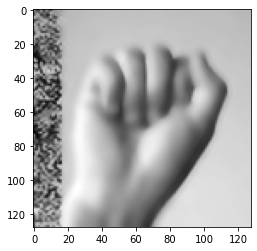

In [575]:
print(grey_img.shape)
plt.imshow(square_and_rescale(grey_img,128, fill_type='int'), 'gray')
plt.show()

In [576]:
img = cv.imread("temp/0.png")

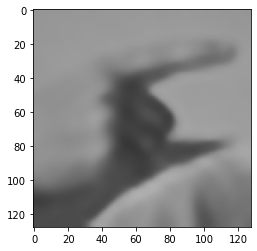

In [577]:
plt.imshow(square_and_rescale(img, 128))
plt.show()

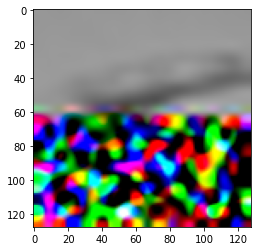

In [587]:
crop = np.float32(img[0:10,5:25])/255
newimg = square_and_rescale(crop, 128, fill_type='gauss', blur='gauss')
plt.imshow(newimg)
plt.show()

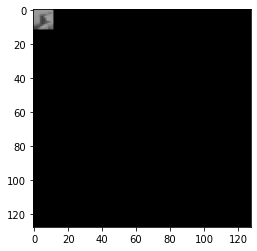

In [585]:
bigimg = np.zeros((300,300,3), dtype=np.uint8)
bigimg[0:28,0:28] = img

newimg = square_and_rescale(bigimg, 128)
plt.imshow(newimg)

In [ ]:
# a dict of all the keys and values that appear (except 'subgroup') in datasets I've tagged
# this isn't used for anything yet (maybe never will)
keywords={'dataset':['cap','dis','grass','mav1','mav2','urgarg'],'subgroup':['none'], 'colour':['greyscale','rbg','bgr'], 
          'crop':['close','none'], 'size':['small','large','128'], 'shape':['square', 'rectangle'],
         'fill':['gauss','uniform','int','zeros']}

In [5]:
# in collecting our datasets together some will use different expressions for the same sign, for example, 'a' and 'A'.
# Here we settle which expression we will use.
def standardise_sign(sign):
    try:
        return sign.lower()
    except:
        return sign
    
# if you change this you will need to alter the next cell as well
splits = ['train','val','hold']
# train is the training data, val is the model cross-validation data, hold is the final check data

In [6]:
# for each dataset, determine which elements go into which splits

# these datasets are composed of subgroups each of which must go into only one split
dis_ord = rng.permutation([1,2,3,4,5])
grs_ord = rng.permutation([1,2,3,4])    
urg_ord = rng.permutation([3,4,5,6,7,9,10])    

dis_split = (3,4,5) # cumulative sum of (3,1,1)
grs_split = (2,3,4) #                   (2,1,1)
urg_split = (5,6,7) #                   (5,1,1)

dis_dict = {'hand'+ str(j) : 'train' for j in dis_ord[0:dis_split[0]]}
dis_dict.update( {'hand'+ str(j) : 'val' for j in dis_ord[dis_split[0]:dis_split[1]] } )
dis_dict.update( {'hand'+ str(j) : 'hold' for j in dis_ord[dis_split[1]:] } )

grs_dict = {'video'+str(j) : 'train' for j in grs_ord[0:grs_split[0]]}
grs_dict.update( {'video'+ str(j) : 'val' for j in grs_ord[grs_split[0]:grs_split[1]]})
grs_dict.update( {'video'+ str(j) : 'hold' for j in grs_ord[grs_split[1]:]})

urg_dict = {'user_'+str(j) : 'train' for j in urg_ord[0:urg_split[0]]}
urg_dict.update( {'user_'+ str(j) : 'val' for j in urg_ord[urg_split[0]:urg_split[1]] } )
urg_dict.update( {'user_'+ str(j) : 'hold' for j in urg_ord[urg_split[1]:]})

# returns name of a list split. 'bad_lbl' is the error return code
def assignment(dataset, subgroup, index=0):
    if dataset == 'cap':
        if subgroup == 'model1':
            return 'train'
        elif subgroup == 'model2':
            try:
                if index % 4 != 0:
                    return 'val'
                else:
                    return 'hold'
            except:
                return 'bad_lbl'
        else:
            return 'bad_lbl'
        
    if dataset == 'dis':
        return dis_dict.get(subgroup, 'bad_lbl')       
    if dataset == 'grass':
        return grs_dict.get(subgroup, 'bad_lbl')
    if dataset == 'urgarg':
        return urg_dict.get(subgroup, 'bad_lbl')
    
    if dataset in ['mav1', 'mav2']:
        try:
            if index % 5 != 0:
                return 'train'
            if index % 15 != 0:
                return 'val'
            if index % 15 == 0:
                return 'hold'
        except:
            return 'bad_lbl'        
    return 'bad_lbl'          

In [7]:
# script for loading datasets saved as numpy arrays. the image filenames should be prefixed with img, the labels with lbl.
path = "datasets/bak/"

imagesets = []
labelsets = []
for file in Path(path).iterdir():
    if not file.is_file():
        continue
    if file.name[0:3] == 'img':
        imagesets.append(np.load(str(file)))
    elif file.name[0:3] == 'lbl':
        labelsets.append(np.load(str(file), allow_pickle=True))

In [9]:
# script for splitting datasets among sets train, val, hold
target_size = 64
fill_type = 'int'
blur_type = 'bilateral'

images = {'bad_lbl':[]}
images.update({key:[] for key in splits})
labels = {'bad_lbl':[]}
labels.update({key:[] for key in splits})

warnings_list = []
target_shape = 'square'
justnow = time.time()
filecount = 0
max_sign_length = 0
for setindex, imgset in enumerate(imagesets):
    for imgindex, img in enumerate(imgset):
        lbl = labelsets[setindex][imgindex]
        if lbl.get('crop', False) != 'close':
            ret, crop = get_hand_from_image(img,
                                        lbl.get('colour','bgr'),
                                        warnings_list)
            if ret:
                img = square_and_rescale(crop,
                                        target_size,
                                        fill_type=fill_type,
                                        blur = blur_type )
            else:
                print(setindex, imgindex, lbl)
                continue
            lbl.update({'crop':'close','shape':'square','size':str(target_size), 'fill':fill_type, 'blur':blur_type})
        else:
            img = square_and_rescale(img,
                                    target_size,
                                    fill_type = fill_type,
                                    blur = blur_type )                                 
            lbl.update({'shape':'square','size':str(target_size),'blur':blur_type})
        assign = assignment(lbl.get('dataset', None), lbl.get('subgroup', None), imgindex)
        if assign == 'bad_lbl':
            print('Bad label generated: ', setindex, imgindex, lbl)
        sign = standardise_sign(lbl['sign'])
        max_sign_length = max(len(sign), max_sign_length)
        lbl.update({'sign': sign})
        if lbl['colour'].lower() == 'bgr':
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            lbl.update({'colour':'rgb'})
        try:
            images[assign].append(img)
            labels[assign].append(lbl)
        except:
            print("Exception: ", setindex, imgindex, assign)
        filecount += 1
now = time.time()
print('Elapsed time: ', now-justnow)
print('FPS: ', filecount/(now-justnow))

5 21 {'dataset': 'urgarg', 'subgroup': 'user_10', 'sign': 'C', 'colour': 'bgr', 'crop': 'none', 'size': 'large', 'shape': 'rectangle'}
Elapsed time:  146.15619254112244
FPS:  259.55793826064775


In [10]:
sign_dtype = '<U' + str(max_sign_length)
lengths = {key : len(labels[key]) for key in splits}
sign_labels = {key: np.zeros((lengths[key]), dtype = sign_dtype) for key in splits}

for key in splits:
    for j in range(0, lengths[key]):
        sign_labels[key][j] = labels[key][j]['sign']

In [11]:
train_l = np.unique(sign_labels['train'])
val_l = np.unique(sign_labels['val'])
hold_l = np.unique(sign_labels['hold'])

In [12]:
# these three numbers should be equal. the underlying sets should be equal. if they are not, something has gone wrong
assert len(train_l) == len(val_l) and len(val_l) == len(hold_l)

In [13]:
len(sign_labels['train']),len(sign_labels['val']), len(sign_labels['hold'])

(27489, 6977, 3470)

In [14]:
# replaces sign string labels with id numbers
encoder = {train_l[ind]:ind for ind in range(0,len(train_l))}

In [15]:
for key in splits:
    for j in range(0,lengths[key]):
        sign_labels[key][j] = encoder[sign_labels[key][j]]
    sign_labels[key] = np.uint8(sign_labels[key])

In [16]:
path = "datasets/"
for key in splits:
    np.save(path + key + "_img_64.npy", images[key])
    np.save(path + key + "_lbl_64.npy", sign_labels[key])

<h3>Input channel expansion</h3>

Shorten-Khoshgoftaar venture that "A disadvantage of this technique [augmentation by kernel filters] is that it is very similar to the internal mechanisms of CNNs. CNNs ... learn the optimal way to represent images layer-by-layer.... Kernel filters can be better implemented as a layer of the network rather than as an addition to the dataset through data augmentation." On the other hand, Kukacka-Golkov-Cremers opine "known meaningful data transformations should not be outsourced to the learning. Redundantly providing the same information in several representations is okay."

In this case I tried adding some Scharr derivatives. It did not help.

In [11]:
imgs = {}
for key in splits:
    imgs[key] = np.load("datasets/" + key + "_img_64.npy")

In [7]:
# augmentation w/ Scharr derivatives
for key in splits:
    Scharr_x = np.zeros_like(imgs[key], dtype='uint8')
    Scharr_y = np.zeros_like(imgs[key], dtype='uint8')
    for j in range(0, len(imgs[key])):
        Scharr_x[j] = cv.Scharr(imgs[key][j], -1, 1, 0)
        Scharr_y[j] = cv.Scharr(imgs[key][j], -1, 0, 1)
    imgs[key] = np.concatenate([imgs[key], Scharr_x, Scharr_y], axis=3)

In [9]:
path = "datasets/"
for key in splits:
    np.save(path + key + "_img_64_Scharr.npy", imgs[key])

<h2>Data Augmentation</h2>

<h3>Supplementing data with synthetics</h3>

Shorten-Khoshgoftaar write positively of (among methods that themselves do not involve ML in their construction) rotations, random erasure, and certain image-mixing methods. (Cropping they find is the most important such augmentation. Since our data is already cropped from bounding boxes, this amounts to the same as translation, which is regarded as a less-effective method when training CNNs.) The image-mixing methods include 'patchwork' transforms that move segments of an image, or replace them with segments from another image, as well as superposition of images (averaging their pixel values), including superposition of images different labels! The apparent senselessness of such manipulations lead them to remark on "the sometimes unreasonable effectiveness of big data with deep learning models."

Among ML-based methods, there is one off-the-shelf method which they recommend, style transfer. They laud it as "is one of the flashiest demonstrations of Deep Learning capabilities," and say its application to data augmentation is "a much more powerful augmentation technique than traditional color space augmentations."

There is a subfield of designing data augmentation strategies to make an 'optimal curriculum.' One ML strategy to tackle this problem is called AutoAugment. Albumentations apparently has an implementation of a subsequent refinement of this method, "Fast AutoAugment." See https://albumentations.ai/docs/autoalbument/ 

In [17]:
import albumentations as al

In [18]:
# apply two transforms, chosen randomly from a number of sublists
synth = al.SomeOf([al.OneOf([al.Rotate(limit=10),
                              al.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=5)]),
                    al.OneOf([al.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.4),
                              al.RandomToneCurve(),
                              al.Equalize()]),
                    al.OneOf([al.Sharpen(alpha=(0.5, 1)),
                                al.CLAHE(),
                                al.Emboss(alpha=(0.5,1), strength=(0.5,1))]),
                    al.FancyPCA(alpha=0.5),
                    al.OneOf([al.CoarseDropout(max_holes=8, max_height=8, max_width=8, 
                                                min_holes=4, min_height=4, min_width=4, 
                                                fill_value=0),
                              al.Spatter(mode='rain', intensity=.6, cutout_threshold=0.68),
                              al.Superpixels(p_replace=0.15)]),
                    al.OneOf([al.GridDistortion(num_steps=5, distort_limit=0.1),
                             al.OpticalDistortion(distort_limit=0.1, shift_limit=0.1)])],
                  n=2, replace=False)

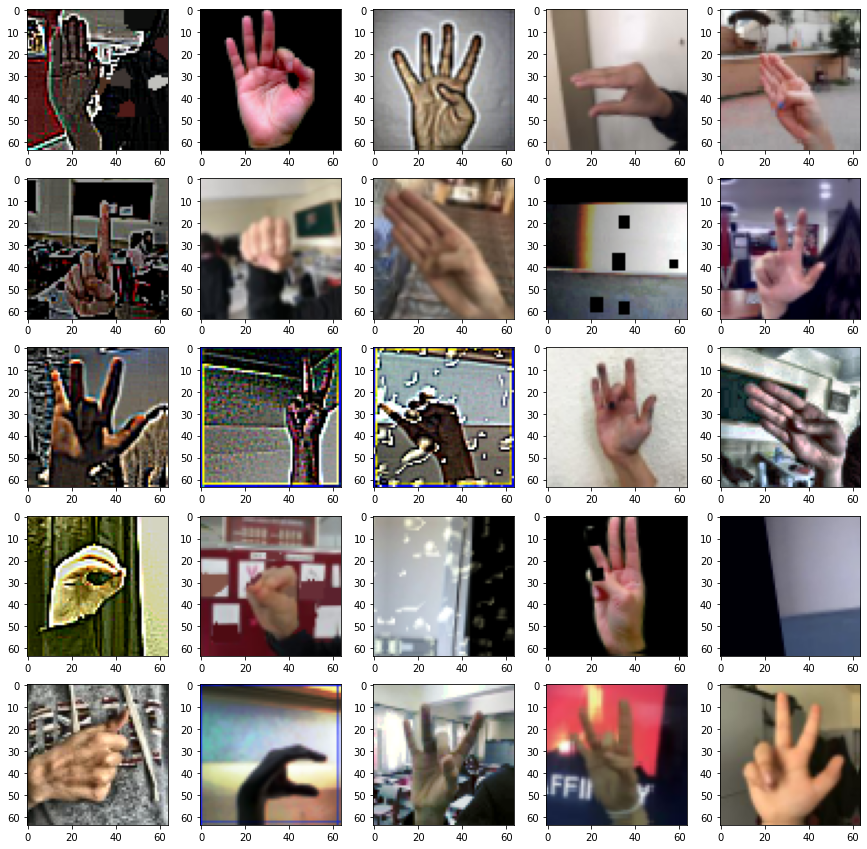

In [19]:
length = len(images['train'])
plt.figure(figsize=(15,15))
for j in range(1,26):
    img = synth(image=images['train'][rng.integers(0,length)])['image']
    plt.subplot(5,5,j), plt.imshow(img)

In [31]:
images_synth = np.zeros((2*length, 64, 64, 3), dtype='uint8')
labels_synth = np.zeros((2*length), dtype='uint8')
justnow = time.time()
for j in range(0, 2*length):
    random_draw = rng.integers(0,length)
    images_synth[j] = synth(image=images['train'][random_draw])['image']
    labels_synth[j] = sign_labels['train'][random_draw]
now = time.time()
print("Elapsed time", now-justnow, ", FPS", 2*length/(now-justnow))

Elapsed time 261.1044340133667 , FPS 210.55942695015864


In [32]:
np.save("datasets/train_img_64_synth.npy", images_synth)
np.save("datasets/train_lbl_64_synth.npy", labels_synth)

There's also a notion of test-time data augmentation: when the trained model is being evaluated, have it randomly generate some synthetic data of the type it's been trained on and see what it predicts for those as well. (Then it can take a vote or whatever.) Perhaps this could partly substitute for lack of sensorimotor variation in the static case. 

What tf does natively/dynamically: Contrast, Brightness, Crop, Flip, Height, Rotation, Translation, Width, Zoom; GaussianNoise

Some Albumentations methods not covered by the above: FancyPCA; CoarseDropout, Spatter, Superpixels; GridDistortion, OpticalDistortion; GlassBlur; Emboss, CLAHE, Sharpen; RandomGridShuffle

<h3>Image mixing</h3>

Examples of an unexpected data augmentation technique: mixing images by averaging their pixel values. Even more surprising, they say it can work even better if you mix images with different labels! (The label of the resulting superposition is randomly chosen from those of its components.)

In [588]:
img1 = cv.cvtColor(cv.imread("temp/A9.jpg"), cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(cv.imread("temp/A8.jpg"), cv.COLOR_BGR2RGB)

In [589]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255

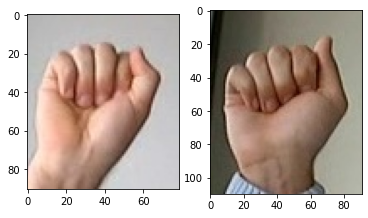

In [591]:
plt.subplot(1,2,1), plt.imshow(img1)
plt.subplot(1,2,2), plt.imshow(img2)
plt.show()

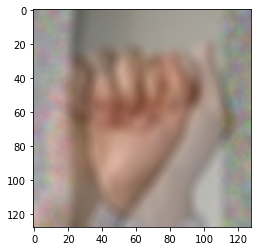

In [592]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3)
plt.show()

In [593]:
img1 = cv.imread('temp/11.png', flags=0)
img2 = cv.imread('temp/45.png', flags=0)

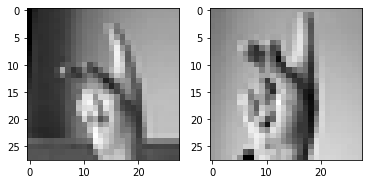

In [594]:
img1 = np.float32(img1)/255
img2 = np.float32(img2)/255
plt.subplot(1,2,1), plt.imshow(img1, 'gray')
plt.subplot(1,2,2), plt.imshow(img2, 'gray')
plt.show()

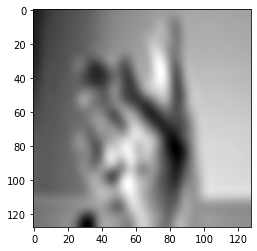

In [596]:
img3 = (square_and_rescale(img1, 128) +square_and_rescale(img2, 128))/2
plt.imshow(img3, 'gray')
plt.show()